<a href="https://colab.research.google.com/github/raymundodiaz/Mytest/blob/master/Classical_credit_scoring_modeling_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'default-of-credit-card-clients-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F306%2F666%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240612%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240612T014909Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4901b610b6b6020a4cf38f1086779d934da99c1edb612a029b767b5d37b2b1b124a5153f1d83a574afd07419df2d4872ce4ecca380e7368c4195d7f039095c2231be2693cb998931ba7f60a19415d6e61fb63c6e0efa46bff769d74451f9616f2fe6198bb5d09c9dccb1c787796dccfd98d4afe410309db1952bde0ae657c069c1f01ee67d028073401e165de32d306a631d7608d8cd892f0dcb1a822e9398e1643dc21fb50e31168bfd27a424fad37bbb461077c5acbfb02f6d9875e4868a7e4699c29d8ba91b454f15cb8ca6dd419bad09778095048bf8f1203864a2ac8235ca1eb03beed26f1d2ae727e8f442a784e1b5fcb6ad029f8f2bc1d817daa02078'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1025318 bytes downloaded
Downloaded and uncompressed: default-of-credit-card-clients-dataset
Data source import complete.


# Classical credit scoring modeling tutorial

In many situations, we want a machine learnning method to sort our clients, products, events by their probabilities, creating an ranking. This is something between regression and classification. It is classification because the output must be between 0 and 1 but it is a regression because we don't want an binary outcome.

The goal of this tutorial is to share the knowledge that I learned modeling credit scoring systems.  I will focus on descriptive analysis, feature engineering, quality reports and indicadors used for scoring.  *Machine learning algorithms are not the goal and I assume the reader has solid knowledge of classififiers*



## Data Set Metadata

- **ID**: ID of each client
- **LIMIT_BAL:** Amount of given credit in NT dollars (includes individual and family/supplementary credit
- **SEX:** Gender (1=male, 2=female)
- **EDUCATION:** (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- **MARRIAGE:** Marital status (1=married, 2=single, 3=others)
- **AGE:** Age in years
- **PAY_0 to PAY_6:** Repayment status at last month until 6 months ago, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- **BILL_AMT1 to BILL_AMT6:** Amount of bill statement at last month until 6 months ago, 2005 (NT dollar)
- **PAY_AMT1 to PAY_AMT6:** Amount of previous payment at last month until 6 months ago, 2005 (NT dollar)

- **default.payment.next.month:** Default payment (1=yes, 0=no)

- <span style="color:red">This dataset doesn't contain an important field: the timestamp. This is crucial for real life machine learning systems</span>

## Key features of a good dataset for modeling tabular data  and scoring

1. The *key/ID* must be unique in combination with item 2.
2. Must contain the *time_id*. Example: create_date, purchase_date, etc. This easily identified as the x-axis on dashboards.
3. The key (item 1) + time_id (item 2) can be seen as a surrogate key.
4. The key/ID shall not have missing values
5. The target must be in the future. Ex.: a client will not pay in the next 1 or 2 months (0 / 1). A client will buy a ticket in the next 10 days (0 /1).... and so on.
6. Oversampling and undersampling must be


```mermaid
  graph TD;
      A-->B;
      A-->C;
      B-->D;
      C-->D;
```

# Modeling steps

## Reading data:
 * For all types:
  * Check missing values: null, none, blanket,  9999..99 (are also common), -1 and so on.
 * Categorical variables:
  * STRING: Clean string variables: trim, normalize cases etc.;
  * INTEGER: are integer variables continuous ou categoric codes.
 * Date and Time:
  * They MUST NOT enter in the model. See the feature engineering bellow.
  
## Population and database design

* Observation definition:
 * You should define which field is the primary-key / key of you observation (or row of the database).
 * Define your population. Should you considere all the documents/clients/entities or a subset of it is enough?
  * Many models are influenced by the proportion of a certain class in the training set and tries to predict the same proportion on the testing set.
  * Example: Are all the people in CRM database the target of your model or only the subset that has already bought someting?
  * Considere undersampling and upsample cautionly because it would require an extra step to calibrate the probabilities.
  
## Feature engineering

* Main tips:
 * All models perform better on variables with linear relationship with the target (not exponential, not unbalanced, not with long tail, and so on).
 * All businesses need to trust your model. Yesterday, to understand the what happened, today, to make decisions, and tomorrow, to forecast risk/revenue/demand/infected etc.
 * The goal in doing feat. engineering is to stabilize the model across time and subsamples.

* For data-time variables:
 * REFDATE: **First** don't mess with the snapshot/reference/month on book/whatever field. ALL DATABASEs must have the data of extration, or the snapshot. This information is part of primary key. They are important for audit, reporting, stability checks, model validation and so on.
  * The refdate is used to create reports.
 * Transform into timedeltas like years (ages), months (time of relationship, month until brankrupcy).
 * When combined with other variables can produce good attributes like (expenses in the last 3 months).

* For String/categorical Data
 * Do you have many categories ? why don't use pareto's law and use only those relevants and group the rest on the "others" category?
 * Do they have similars meaning: "single", "divorced"?  Why not group then "single-divord"?
 * Do they have same odds ratio? group them.
 * Do they have order: low, medium, high ? why don't replace them by the mean of the target on a sample?
 * Keep the number o categories manageable, around 3 to 10.
 * Do you have only 2 categs ? why not create only one binary var: ex. gender (male, female) ==> (isFemale)
 * Pseudo-categorical: ex. education (high school, college, etc) can hide a continous variables, years of education.


* For real/floating variables:
 * **Monetary values**: They are prices, income, payments, costs, rents, exchange rate, etc. **IN 99% of cases DON'T USE** them direct in your model. They fragile and oscilate acording to macro-economic movements, like inflation, demand, etc. Create relative variables  like BALANCE_INCOME = BALANCE / BASIC_INCOME_AT_MONTH.
 * Take care with fake precision.  Does 5.009943323 dollars mean something? why not truncated it to 5.01?
 * What is a good range for percentages variables ?


* For integer variables:
 * Counting variables usually have very assymetric distribuition. Sometimes grouping them into 1, 2, >=3 leads to good results.
 * **Especial Cases**:
  * **Age**: age are usually measured in years and are highly corrected with marriage status, education and so on. It's distribuion should be checked against the country's demography distribuition to prevent unwanted biaes. In many case, considere create a categorial variable = 19-23 (college age), 23-27 (first job), 27-32 (senior posions), 60-high (retired) etc.
  

* Derived attributes:
 * Lagging attributes:
  * Ex: What was the client last status?  Has the machine failed in the last 10 days (for maintainance prediction)?
 * Ratios, variations and deltas attributes: They usually helps to stabilize the model.
  * Ex: ratio between the load and the truck strengh ( Load_Stress = boad/strengh). Ratios can be greater than one.
  * Ex: Balanced_used = (expences/balanced). Proportions should be less than one, specially when they express probabilities.
  

* External attributes:
 * Other scores - bureau score: should be used as last resource due to its cost and vunerable to providers errors.
  
  
  
Concepts:
* **Stable model**: a model the is stable across time and subsamples.
* **Future data**: an attribute that uses informations only available after the Snapshot, therefore will break your model.

# Comments

-  Real credit datasets have at least 12 months and not one month because people behave different after christimas, vantines day etc.
--  The variable YMS will be created to **S**imulate **Y**ear**M**onth

- The lagging variable PAY_0  seems to be PAY_1 like the others variables



In [4]:
!pip install -U --quiet shap scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 40.6 MB/s eta 0:00:00


In [5]:
%matplotlib inline

#basic data analysis libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pylab as plt
import seaborn as sns
sns.set_style("whitegrid")

from IPython.display  import HTML
#import sweetviz

In [6]:
#machine learning libraries
import sklearn
from sklearn.metrics import pairwise_distances
#from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import shapely

print(f'sklearn = {sklearn.__version__}')
print(f'pandas = {pd.__version__}')

sklearn = 1.5.0
pandas = 2.0.3


## Loading data and doing preprocessing

**In real world situation, all economic data must be validate through time. Given the original dataset lacks this information, I'm creating a artificial field "reference date" for tutorial purpose.**

In [7]:
def createSimulatedDate(lenght):
    date = np.ceil(10*np.random.RandomState(seed=42).rand(lenght)).clip(1,10);
    date = date.astype(int)
    date = [f"2010-{i:02d}" for i in date];
    return pd.to_datetime(date);


df = (
    pd
    .read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
    .rename(columns={'default.payment.next.month':'target','PAY_0':'PAY_1'})
    .assign(
        dt_ref=lambda x: createSimulatedDate(len(x)), #simulating datetime
        sample_id=lambda x: np.ceil(10*np.random.RandomState(seed=42).rand(len(x))).clip(1,10),
        isTrain=lambda x: x['sample_id'] < 7  #using hold out in a time frame
    )

)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target,dt_ref,sample_id,isTrain
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,689.0,0.0,0.0,0.0,0.0,1,2010-04-01,4.0,True
1,2,120000.0,2,2,2,26,-1,2,0,0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,2010-10-01,10.0,False
2,3,90000.0,2,2,2,34,0,0,0,0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,2010-08-01,8.0,False
3,4,50000.0,2,2,1,37,0,0,0,0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,2010-06-01,6.0,True
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,2010-02-01,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0,2010-10-01,10.0,False
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,1837.0,3526.0,8998.0,129.0,0.0,0.0,0,2010-08-01,8.0,False
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1,2010-01-01,1.0,True
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1,2010-05-01,5.0,True


# Basic EDA

When we get the data for the first time is good to check if it comes with all necessary fields, if they are filled correctly, and so on.

Pandas profilling and other libraries can help at this stage of the development. But as we advances in the analysis more and more manual treating is need to ensure that the data is good to go.

In [8]:
(
    df
    .describe(percentiles=[0.1,0.25,0.5,0.75,0.8,0.9])
    .T.drop(columns=['count'])
    .style.background_gradient(axis=1)
)

,mean,min,10%,25%,50%,75%,80%,90%,max,std
ID,15000.500000,1.000000,3000.900000,7500.750000,15000.500000,22500.250000,24000.200000,27000.100000,30000.000000,8660.398374
LIMIT_BAL,167484.322667,10000.000000,30000.000000,50000.000000,140000.000000,240000.000000,270000.000000,360000.000000,1000000.000000,129747.661567
SEX,1.603733,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.489129
EDUCATION,1.853133,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,6.000000,0.790349
MARRIAGE,1.551867,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,0.521970
AGE,35.485500,21.000000,25.000000,28.000000,34.000000,41.000000,43.000000,49.000000,79.000000,9.217904
PAY_1,-0.016700,-2.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,2.000000,8.000000,1.123802
PAY_2,-0.133767,-2.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,8.000000,1.197186
PAY_3,-0.166200,-2.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,8.000000,1.196868
PAY_4,-0.220667,-2.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,8.000000,1.169139


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ID         30000 non-null  int64         
 1   LIMIT_BAL  30000 non-null  float64       
 2   SEX        30000 non-null  int64         
 3   EDUCATION  30000 non-null  int64         
 4   MARRIAGE   30000 non-null  int64         
 5   AGE        30000 non-null  int64         
 6   PAY_1      30000 non-null  int64         
 7   PAY_2      30000 non-null  int64         
 8   PAY_3      30000 non-null  int64         
 9   PAY_4      30000 non-null  int64         
 10  PAY_5      30000 non-null  int64         
 11  PAY_6      30000 non-null  int64         
 12  BILL_AMT1  30000 non-null  float64       
 13  BILL_AMT2  30000 non-null  float64       
 14  BILL_AMT3  30000 non-null  float64       
 15  BILL_AMT4  30000 non-null  float64       
 16  BILL_AMT5  30000 non-null  float64      

## Feature engineering

Feature engineering is sometimes more efective to boost models than complex methods. This happens because we are injecting domain knowledge into the model and opening the black-box.

In some cases, feature engineering is totally necessary

Limit_bal  and bill_amt can vary by income, region, time/inflation etc  and these informations are not included in the dataset.  So, the best way of creating stable feature is by calculate relative metrics

In [10]:
def lag_indicator(df, min_=1,max_=7):
    for i in range(min_,max_):
        df['IU'+str(i)]= df['BILL_AMT'+str(i)] / df['LIMIT_BAL'];
        df['PER_PAYED'+str(i)]= df['PAY_AMT'+str(i)] / df['BILL_AMT'+str(i)]
        df['PER_PAYED'+str(i)] = df['PER_PAYED'+str(i)].replace([np.inf, -np.inf], np.nan).fillna(0);

    months = (6 - np.arange(6)).reshape(1,-1)
    #see if the IU and percent payed is increasing or decreasing with time, a.k.a, has correlation

    fields_per_payed = ['PER_PAYED'+str(i) for i in range(min_,max_)]
    df['TREND_PER_PAYED'] = 1- pairwise_distances(df[fields_per_payed],months,metric='correlation');
    df['TREND_PER_PAYED'] = df['TREND_PER_PAYED'].replace([np.inf, -np.inf], np.nan).fillna(0)

    fields_IU = ['IU'+str(i) for i in range(min_,max_)]
    df['TREND_PER_IU'] = 1- pairwise_distances(df[fields_IU],months,metric='correlation')
    df['TREND_PER_IU'] = df['TREND_PER_IU'].replace([np.inf, -np.inf], np.nan).fillna(0)
    return df;


df = (
    df
    .copy()
    .assign(
        SEX=lambda x:x['SEX'],  # Binarizing
        MARRIED=lambda x:x['MARRIAGE'].apply(lambda xx: 1 if xx == 1 else 0), # Binarizing

        #convert to years of study --- education == null ==> 0 years (worst case scenario)
        EDUCATION=lambda x:x['EDUCATION'].fillna(0).map({1:5,2:15, 3:9, 4:0, 5:0, 6:0, 0:0}),
    )
    .pipe(lag_indicator)
)

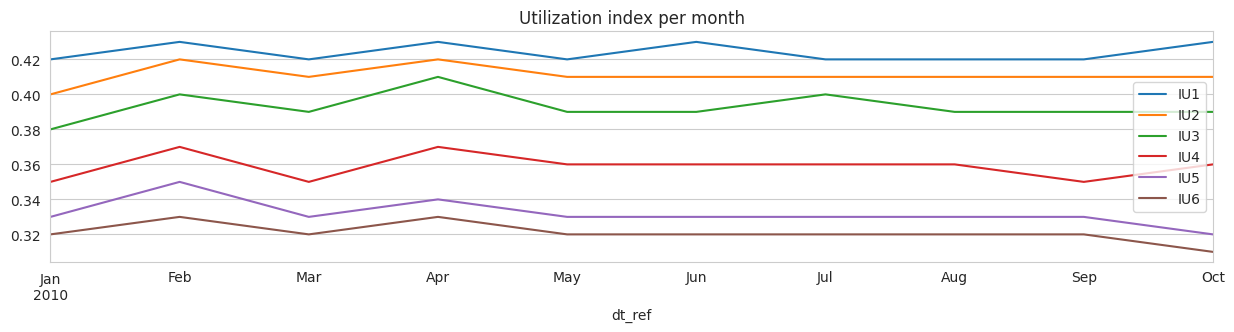

In [11]:
(
    df[['IU'+str(i) for i in range(1,7)] + ['dt_ref']]
    .groupby('dt_ref')
    .mean()
    .round(2)
    .plot(figsize=(15,3), title="Utilization index per month")
)

plt.legend(loc='best');
plt.grid(True);

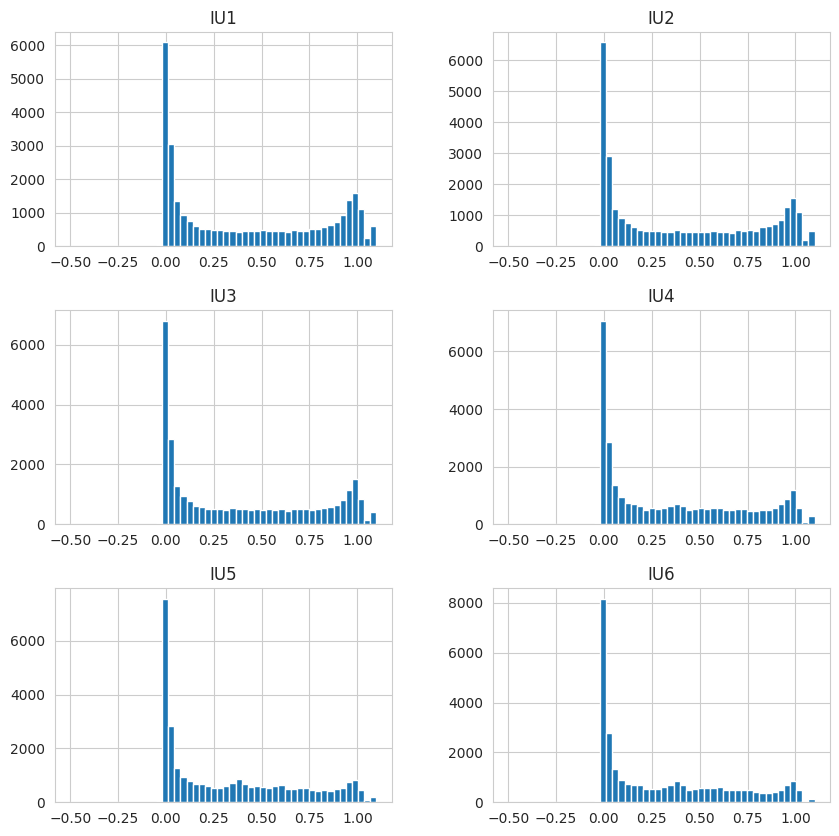

In [12]:
df[['IU'+str(i) for i in range(1,7)]].clip(-0.5,1.1).hist(bins=50, figsize=(10,10));
# IU > 1 means something has overflew from one month to next, probably.

Are there any trend from 6th to the last month ?  the correlation of the percentages with the vector [1,2,3,4,6] is positive?

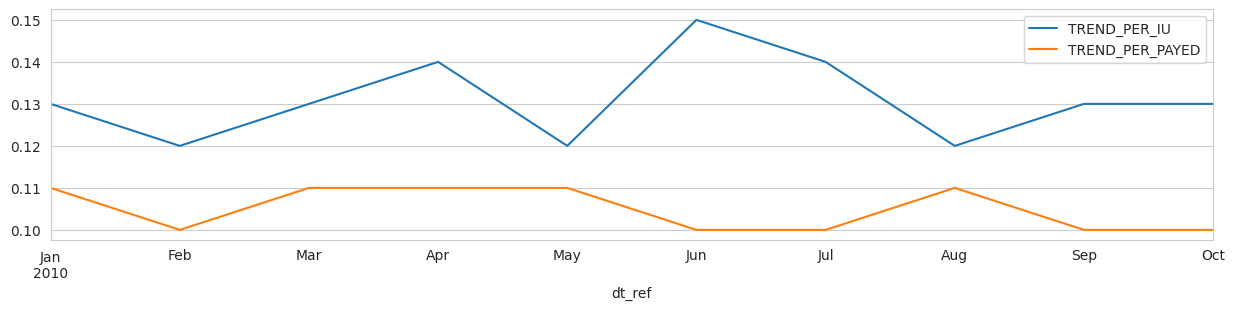

In [13]:
(
    df[['TREND_PER_IU','TREND_PER_PAYED'] + ['dt_ref']]
    .groupby('dt_ref')
    .mean()
    .round(2)
    .plot(figsize=(15,3))
)
plt.legend(loc='best');
plt.grid(True);

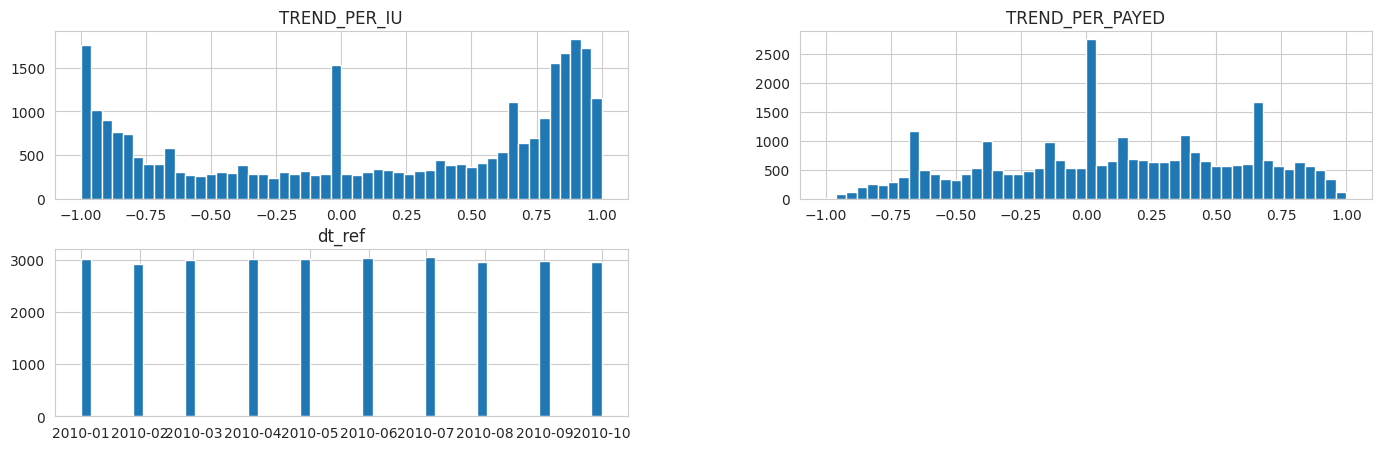

In [14]:
df[['TREND_PER_IU','TREND_PER_PAYED'] + ['dt_ref']].hist(bins=50, figsize=(17,5));
#yes, there are some cases

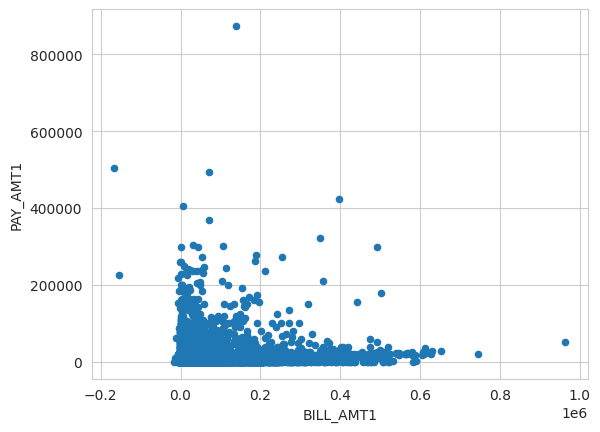

In [15]:
df.plot.scatter(x='BILL_AMT1',y='PAY_AMT1');

The **EDA_continuous_v1** function encodes the following design/business informations:
- the univarate analisys - Stats table and the histogram - where outliers can be seem.
- Continuous variavels are grouped by percentile with each bucket containing 1% of the data.
- the bivariate analysis contains the relationship between the mean of the bucket with mean of the target.
-- desireable attribute has linear relationship / correlation

In [16]:
def EDA_continuous_v1(df, var,target='target', datetime='dt_ref', preprocess=None, hist_bins=100, figsize=(10,5)):
    display(HTML("EDA %s"%var))
    display(df[var].to_frame().describe(percentiles=np.linspace(0,1,11)).round(2).T)

    plt.figure(figsize=figsize);

    ### plot 1
    plt.subplot(121);
    plt.title(" Histogram - %s"%var);
    df[var].hist(bins=hist_bins, density=True);
    plt.xlabel(var);

    ### plot 2
    plt.subplot(122);
    temp =pd.DataFrame({
        'rank': KBinsDiscretizer(n_bins=hist_bins, encode='ordinal').fit_transform(df[[var]]).flatten(),
        'rank_cluster': KBinsDiscretizer(n_bins=5,strategy='kmeans', encode='ordinal').fit_transform(df[[var]]).flatten(),
        var: preprocess(df[var].values) if preprocess is not None else df[var],
        target:df[target],
        datetime:df[datetime]
    })
    sns.regplot(x=var,y=target,ax=plt.gca(), data=temp.groupby('rank').mean());

    plt.title("Correlation %0.4f" % temp.groupby('rank').mean().corr().values[0,1]);
    plt.tight_layout();
    plt.show();

    #plot 3
    plt.figure(figsize=(figsize[0],3))
    ax = plt.gca();
    temp.pivot_table(index=datetime, columns='rank_cluster',values=target).plot(ax=ax);
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=10);
    ax.set_xlabel(datetime);
    ax.set_ylabel(f"Mean {target}");
    ax.set_title(f"{target} per cluster of {var} over time");
    plt.tight_layout();
    plt.show();

    display(
        temp
        .drop(columns=['rank_cluster'])
        .groupby('rank').mean()
        .style.background_gradient(axis=0)
        .format(precision=3)
    )

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
AGE,18026.0,35.5,9.26,21.0,21.0,25.0,27.0,29.0,31.0,34.0,37.0,40.0,44.0,49.0,75.0,75.0


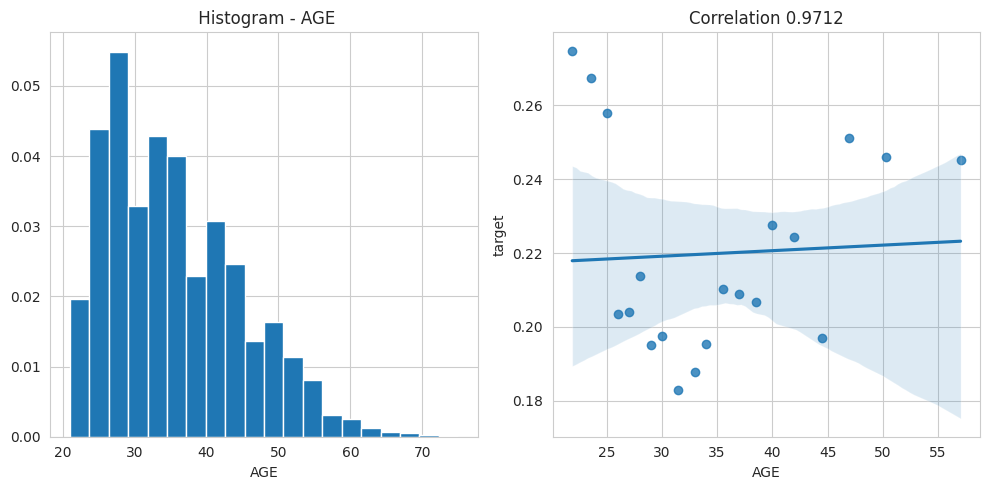

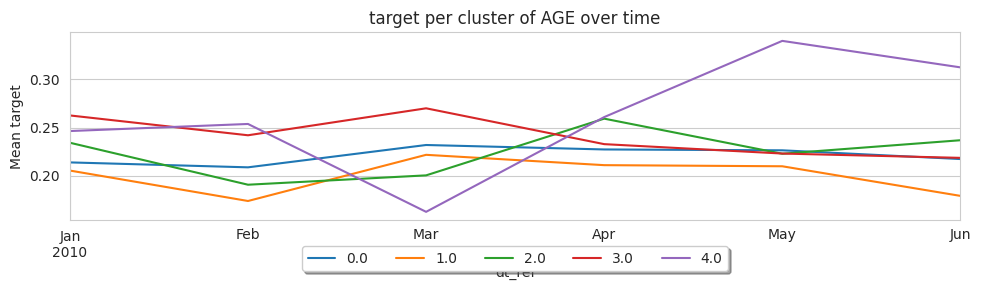

,AGE,target,dt_ref
rank,,,
0.000000,21.891,0.275,2010-03-16 01:20:36.641221376
1.000000,23.546,0.268,2010-03-17 11:19:58.066075648
2.000000,25.000,0.258,2010-03-19 10:20:58.452721920
3.000000,26.000,0.203,2010-03-18 22:06:36.850393600
4.000000,27.000,0.204,2010-03-15 00:47:53.394495488
5.000000,28.000,0.214,2010-03-19 07:36:55.384615424
6.000000,29.000,0.195,2010-03-15 20:36:11.900826368
7.000000,30.000,0.198,2010-03-17 09:27:31.764706048
8.000000,31.480,0.183,2010-03-15 14:45:04.972375808


In [17]:
EDA_continuous_v1(df.query('sample_id < 7'),'AGE',hist_bins=20)

**TREND_PER_IU** relationship with the target contains a inverted "v" shape in the lower valeus what may indicated this variable should be used and categorical (each category representing parts of the curve)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
TREND_PER_IU,18026.0,0.13,0.7,-1.0,-1.0,-0.91,-0.73,-0.38,0.0,0.27,0.58,0.75,0.85,0.92,1.0,1.0


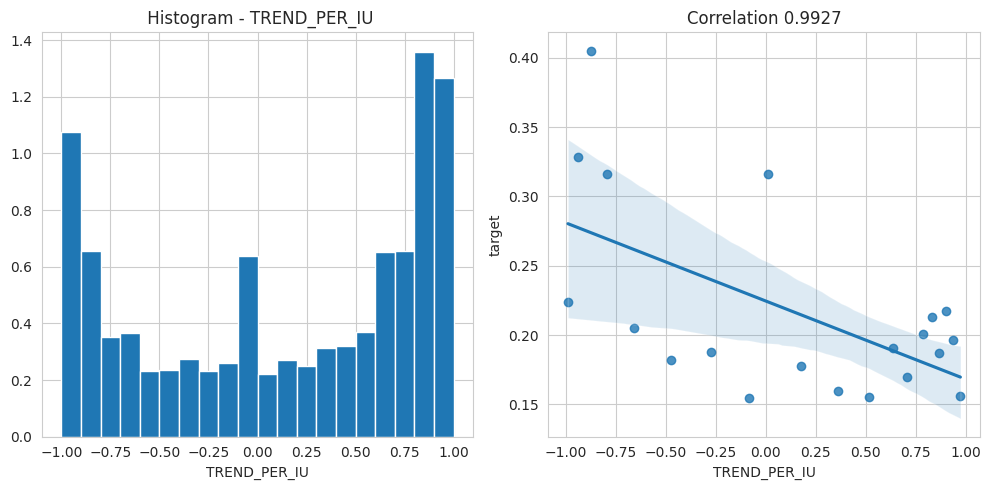

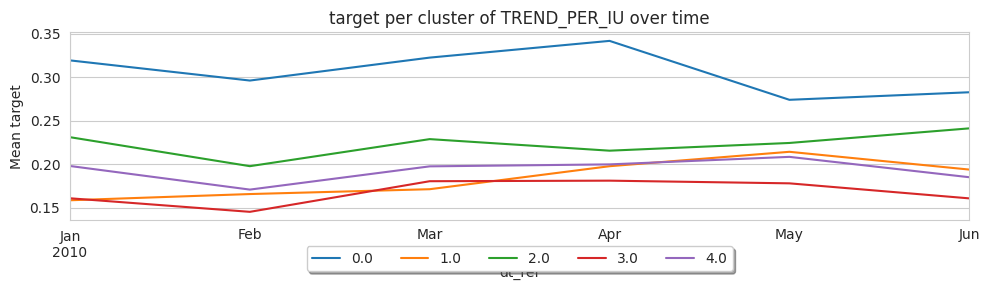

,TREND_PER_IU,target,dt_ref
rank,,,
0.000000,-0.988,0.224,2010-03-15 10:27:24.345897984
1.000000,-0.940,0.329,2010-03-19 08:39:25.371809024
2.000000,-0.875,0.405,2010-03-16 23:26:26.237513984
3.000000,-0.792,0.316,2010-03-20 02:46:12.918978816
4.000000,-0.657,0.205,2010-03-14 13:35:47.228381184
5.000000,-0.472,0.182,2010-03-16 01:26:18.246392832
6.000000,-0.274,0.188,2010-03-17 20:56:12.253052160
7.000000,-0.086,0.155,2010-03-18 00:09:36.769025280
8.000000,0.012,0.316,2010-03-16 20:00:54.648956416


In [18]:
EDA_continuous_v1(df.query('sample_id < 7'),'TREND_PER_IU',hist_bins=20)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
TREND2_PER_PAYED,18026.0,0.59,0.27,0.0,0.0,0.21,0.34,0.39,0.51,0.61,0.69,0.8,0.87,0.97,1.0,1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


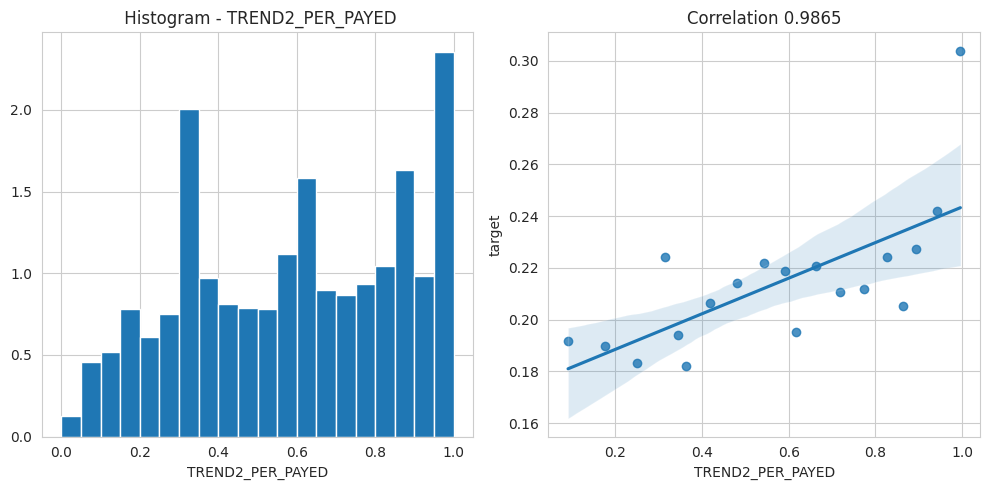

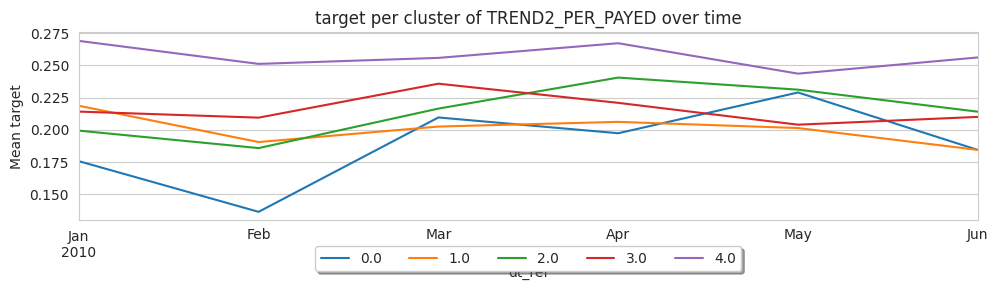

,TREND2_PER_PAYED,target,dt_ref
rank,,,
0.000000,0.091,0.192,2010-03-15 13:58:08.248336896
1.000000,0.175,0.190,2010-03-16 17:41:13.251942400
2.000000,0.250,0.183,2010-03-17 20:24:14.384017664
3.000000,0.313,0.224,2010-03-16 18:48:20.776914432
4.000000,0.344,0.194,2010-03-16 16:55:20.620842496
5.000000,0.363,0.182,2010-03-18 19:21:54.539400704
6.000000,0.418,0.206,2010-03-17 10:42:29.167591424
7.000000,0.480,0.214,2010-03-15 10:36:05.593784832
8.000000,0.543,0.222,2010-03-19 09:47:29.667405824


In [19]:
#applying the transformation seen above that make the relationship more linear
df['TREND2_PER_PAYED'] = 1-np.abs(df['TREND_PER_PAYED'].values)
EDA_continuous_v1(df.query('sample_id < 7'),'TREND2_PER_PAYED',hist_bins=20) # trend2 contains the intensity of the direction

## Age var

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
AGE,18026.0,35.5,9.26,21.0,21.0,25.0,27.0,29.0,31.0,34.0,37.0,40.0,44.0,49.0,75.0,75.0


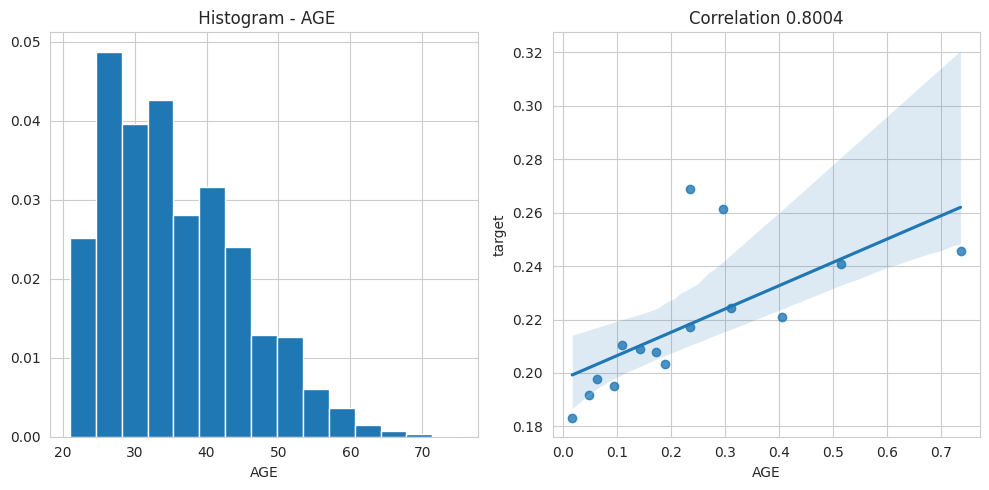

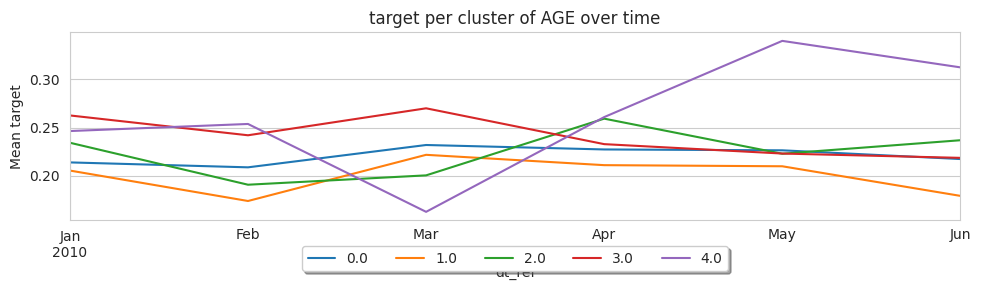

,AGE,target,dt_ref
rank,,,
0.000000,0.296,0.262,2010-03-15 11:20:50.209204992
1.000000,0.234,0.269,2010-03-19 10:48:50.232558080
2.000000,0.188,0.203,2010-03-18 22:06:36.850393600
3.000000,0.141,0.209,2010-03-17 03:00:00
4.000000,0.094,0.195,2010-03-15 20:36:11.900826368
5.000000,0.062,0.198,2010-03-17 09:27:31.764706048
6.000000,0.016,0.183,2010-03-15 14:45:04.972375808
7.000000,0.047,0.192,2010-03-18 06:54:59.135446784
8.000000,0.109,0.210,2010-03-16 07:50:00.446096640


In [20]:
EDA_continuous_v1(df.query('sample_id < 7'),'AGE', preprocess=lambda x: abs(x-32)/32,hist_bins=15) # how far you are from 32yo. / 32 is when the parabole changes upward again

In [21]:
df['AGE_NORM'] = np.abs(df['AGE']-32)/32

### Creating a categorical variables from non-linear or unstable variables.

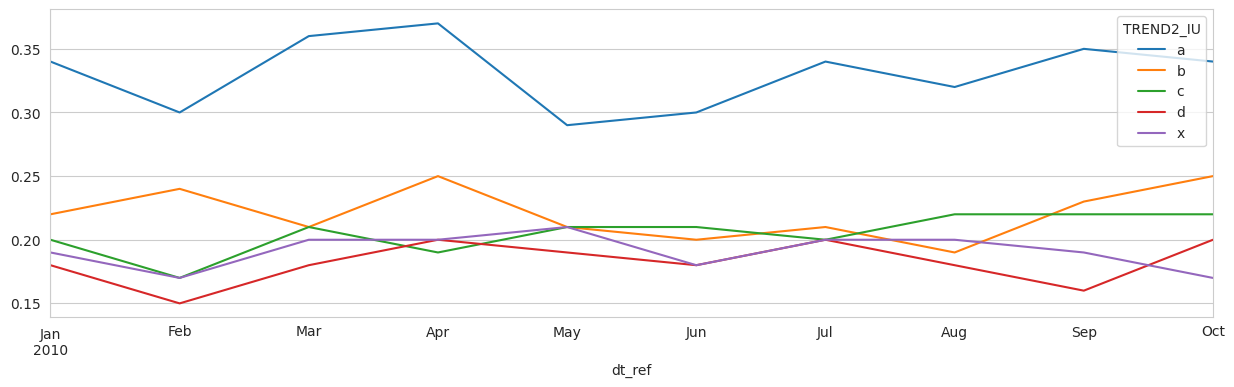

In [22]:
def temp(x):
    if x < -0.8:
        return 'a';
    elif x < -0.5:
        return 'b';
    elif x < 0.5:
        return 'c';
    elif x < 0.8:
        return 'd';
    else:
        return 'x';

df['TREND2_IU']=df['TREND_PER_IU'].apply(temp)
(
    df
    .pivot_table(index='dt_ref',columns='TREND2_IU',values='target')
    .round(2)
    .plot(figsize=(15,4))
);

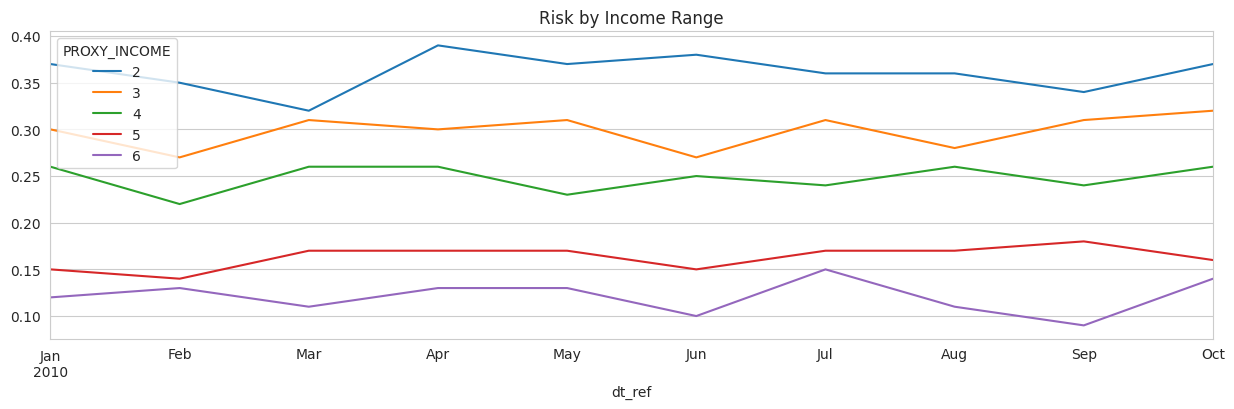

In [23]:
def income2Range(x):
    # income are generaly exponential.
    x = x/1000;

    return str(int(np.log(x)))

# Assuming the limit gave to the client has to something to do with his income.
# in the practice the risk + income defines the limit. So in the real world using the limit as input would break your model.
df['PROXY_INCOME']=df['LIMIT_BAL'].apply(income2Range)
(
    df
    .pivot_table(index='dt_ref',columns='PROXY_INCOME',values='target')
    .round(2)
    .plot(figsize=(15,4), title='Risk by Income Range')
);

display(HTML("We can see that different limits/incomes has different risks"))

## Auxiliary functions / reports

In [24]:
def model_report(df, query_test, target='target',prob='prob', time_id='dt_ref'):
    def model_stats(x):
        s = pd.Series({
            'prob':x[prob].mean(),
            target:x[target].mean(),
            'count':len(x),
            'event':x[target].sum(),
            'non_event': len(x) - x[target].sum()
        });
        return s

    temp = (
        df.query(query_test)
        .groupby('score').apply(model_stats).round(2)
        .assign(per_count=lambda x:x['count'] / x['count'].sum())
        .assign(per_event=lambda x:x['event'] / x['event'].sum())
        .assign(non_per_event=lambda x:x['non_event'] / x['non_event'].sum())
        .assign(odds=lambda x:x['per_event']/x['non_per_event'])
        .assign(per_pop_acc=lambda x:x['count'].cumsum()/x['count'].sum())
        .assign(per_event_acc=lambda x:x['event'].cumsum()/x['event'].sum())
        .assign(lift=lambda x:x[target] / ( x['event'].sum()/ x['count'].sum()))
    );

    display(temp.reset_index().round(2))
    temp_total = temp.mean();
    display(temp_total.to_frame().T.round(2))

    plt.figure(figsize=(12,8))
    plt.subplot(221);
    temp.plot.scatter(x='prob',y=target,ax=plt.gca());
    plt.xlabel('Prob');
    plt.xlabel('Mean target');

    plt.subplot(222);
    plt.title('Strategy plot')
    temp[['per_pop_acc','per_event_acc']].plot(ax=plt.gca());
    plt.grid();
    #print(temp.reset_index().columns)

    plt.subplot(223);
    plt.title('KS %0.2f'% np.abs( temp['per_event'].cumsum() -temp['non_per_event'].cumsum()).max())
    temp.reset_index().plot.bar(x='prob',y=['per_event','non_per_event'],ax=plt.gca());

    #ROC
    fpr, tpr, _ = roc_curve(df[target],df[prob])
    roc_auc = auc(fpr, tpr)

    plt.subplot(224);
    plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc);
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('ROC curve');
    plt.legend(loc="lower right");
    plt.tight_layout();
    plt.show();


    # stability
    plt.figure(figsize=(12,4), tight_layout=True)
    plt.subplot(121);
    df_score = df.pivot_table(index=time_id,columns='score',values=target);
    df_score.plot(ax=plt.gca());
    plt.title("Score stability");

    plt.subplot(122);
    df.pivot_table(
        index=time_id,
        columns='score',
        values=target,
        aggfunc='count').plot(ax=plt.gca(), kind='bar', stacked=True)
    plt.title("Score stability");
    plt.show();

    from scipy import stats;

    scores = np.sort(df['score'].unique());
    test = []
    for i in range(len(scores)-1):
        test.append({
            'score_1':i,
            'score_2':i+1,
            #'ks_normal_test_score_1': round(stats.kstest(df_score[scores[i]],'norm')[0],5),
            'p_value_test':round(stats.ttest_rel(df_score[scores[i]], df_score[i+1])[1],5),
            'cv_1': stats.variation(df_score[scores[i]]),
            'per_invertion': (df_score[scores[i]] > df_score[scores[i+1]]).mean(),
        })

    display(pd.DataFrame(test))


#model_report(df,'YMS >= 7')

In [25]:
def createCluster(df, n_bins=10, train_query='sample_id < 7'):
    binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
    binner.fit(df.query(train_query)[['prob']])
    return binner.transform(df[['prob']])

# First step should be analyze the correlation between variable

# Standard model with Statsmodel Logistic Regression

## advantages:
- Brings confidence intervals for the parameters
- Provide advanced model good of fitness reports
- Allows feature engineering without requiring a pipeline, just using R formulas

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# suggested variables - feel free to change
vars = [
    'PROXY_INCOME',
    'TREND2_IU',
    'TREND_PER_PAYED' ,
    'SEX',
    'MARRIED',
    'IU1',
    'AGE_NORM'
];

df2 = df.copy().replace([np.inf, -np.inf], np.nan).fillna(0);

logit_mod = logit('target ~ ' + (' + '.join(vars)), df2.query('sample_id < 7'))
logit_res = logit_mod.fit(disp=0)
display(logit_res.summary())

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x, n_bins=7)
    )
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                18026
Model:                          Logit   Df Residuals:                    18012
Method:                           MLE   Df Model:                           13
Date:                Wed, 12 Jun 2024   Pseudo R-squ.:                 0.04391
Time:                        01:52:47   Log-Likelihood:                -9049.7
converged:                       True   LL-Null:                       -9465.4
Covariance Type:            nonrobust   LLR p-value:                2.684e-169
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1566      0.097     -1.621      0.105      -0.346       0.033
PROXY_INCOME[T.3]    -0.2780      0.069     -4.058      0.000      -0.412      -0.144
PROXY_INCOME[T.4]    -0.4786      0.067     -7.145      0.000      -0.610      -0.347
PROXY_INCOME[T.5]    -0.9381      0.068    -13.826      0.000      -1.071      -0.805
PROXY_INCOME[T.6]    -1.3030      0.113    -11.543      0.000      -1.524      -1.082
TREND2_IU[T.b]       -0.4443      0.072     -6.202      0.000      -0.585      -0.304
TREND2_IU[T.c]       -0.5074      0.054     -9.450      0.000      -0.613      -0.402
TREND2_IU[T.d]       -0.7792      0.063    -12.384      0.000      -0.903      -0.656
TREND2_IU[T.x]       -0.8493      0.059    -14.464      0.000      -0.964      -0.734
TREND_PER_PAYED      -0.2346      0.040     -5.862      0.000      -0.313      -0.156
SEX                  -0.1536      0.038     -4.060      0.000      -0.228      -0.079
MARRIED               0.1989      0.039      5.134      0.000       0.123       0.275
IU1                   0.3569      0.054      6.632      0.000       0.251       0.462
AGE_NORM              0.1562      0.096      1.634      0.102      -0.031       0.344
=====================================================================================
"""

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.12,0.13,2525.0,317.0,2208.0,0.21,0.12,0.24,0.49,0.21,0.12,0.58
1,1.0,0.16,0.18,2829.0,504.0,2325.0,0.24,0.19,0.25,0.75,0.45,0.30,0.80
2,2.0,0.21,0.21,2302.0,472.0,1830.0,0.19,0.18,0.20,0.89,0.64,0.48,0.93
3,3.0,0.26,0.25,1875.0,474.0,1401.0,0.16,0.18,0.15,1.16,0.80,0.66,1.11
4,4.0,0.32,0.33,1268.0,424.0,844.0,0.11,0.16,0.09,1.73,0.90,0.81,1.47
5,5.0,0.38,0.41,804.0,330.0,474.0,0.07,0.12,0.05,2.40,0.97,0.94,1.82
6,6.0,0.46,0.47,371.0,175.0,196.0,0.03,0.06,0.02,3.07,1.00,1.00,2.09


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.27,0.28,1710.57,385.14,1325.43,0.14,0.14,0.14,1.5,0.71,0.61,1.26


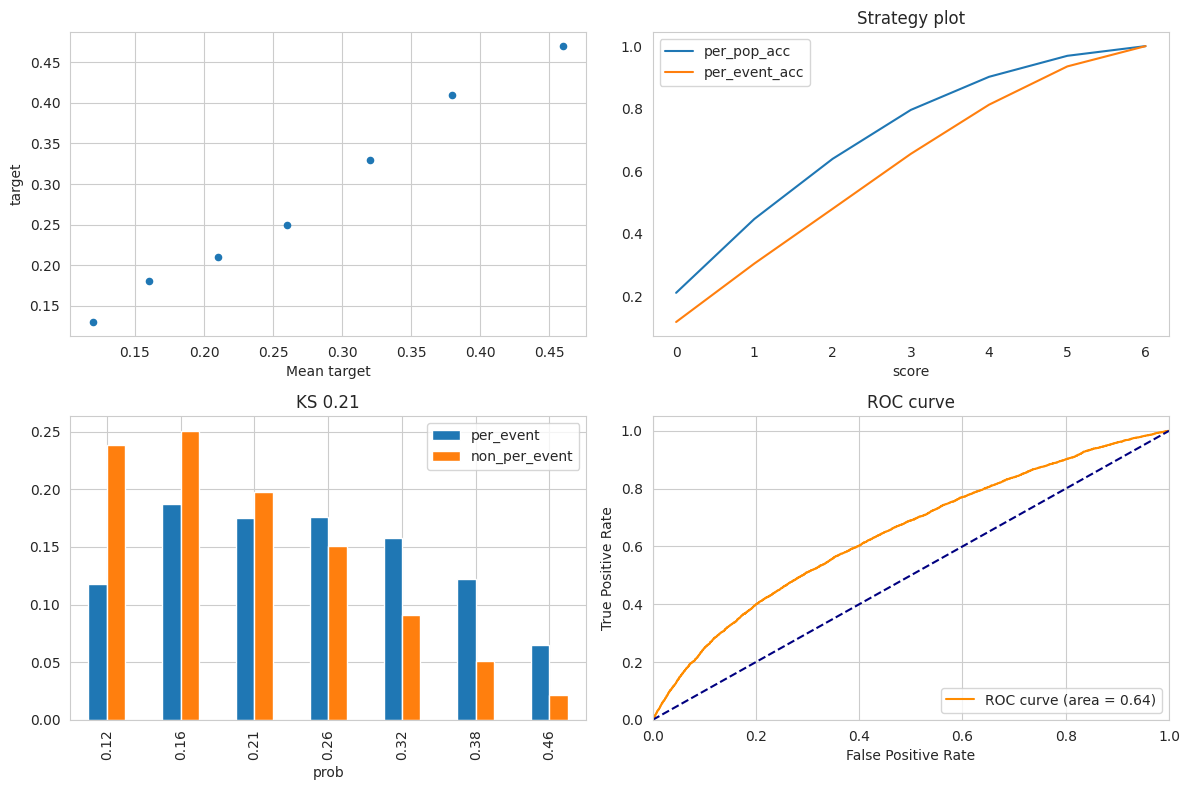

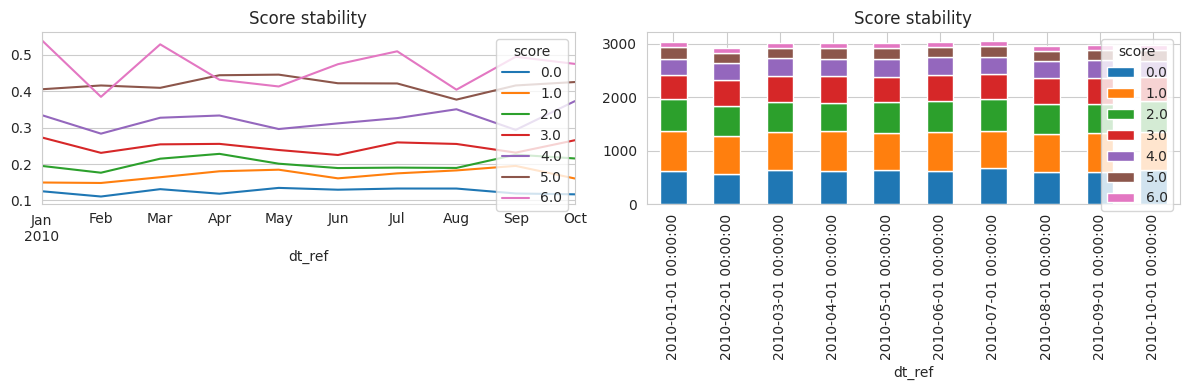

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00001,0.062380,0.0
1,1,2,0.00016,0.088029,0.0
2,2,3,0.00008,0.082096,0.0
3,3,4,0.00000,0.062266,0.0
4,4,5,0.00002,0.080539,0.0
5,5,6,0.03299,0.044328,0.3


In [27]:
model_report(df,'sample_id >= 7 ')

# Let's try some machine learning models
    
    
    
    

sklearn can't deal with string/variables variables so we need to create dummies

In [28]:
df2 = df.copy().replace([np.inf, -np.inf], np.nan).fillna(0);

# creating the dummies manually
dummy = pd.get_dummies(df[['PROXY_INCOME','TREND2_IU']],drop_first=True,prefix=['PROXY_INCOME','TREND2_IU'])
df2 = pd.concat([
    df,
    dummy
], axis=1)

vars = [
    'SEX',
    'MARRIED',
    'TREND_PER_PAYED' ,
    'IU1',
] + dummy.columns.tolist()

### Let's try regularized logistic regression

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.12,0.13,2525.0,317.0,2208.0,0.21,0.12,0.24,0.49,0.21,0.12,0.58
1,1.0,0.16,0.18,2829.0,504.0,2325.0,0.24,0.19,0.25,0.75,0.45,0.30,0.80
2,2.0,0.21,0.21,2302.0,472.0,1830.0,0.19,0.18,0.20,0.89,0.64,0.48,0.93
3,3.0,0.26,0.25,1875.0,474.0,1401.0,0.16,0.18,0.15,1.16,0.80,0.66,1.11
4,4.0,0.32,0.33,1268.0,424.0,844.0,0.11,0.16,0.09,1.73,0.90,0.81,1.47
5,5.0,0.38,0.41,804.0,330.0,474.0,0.07,0.12,0.05,2.40,0.97,0.94,1.82
6,6.0,0.46,0.47,371.0,175.0,196.0,0.03,0.06,0.02,3.07,1.00,1.00,2.09


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.27,0.28,1710.57,385.14,1325.43,0.14,0.14,0.14,1.5,0.71,0.61,1.26


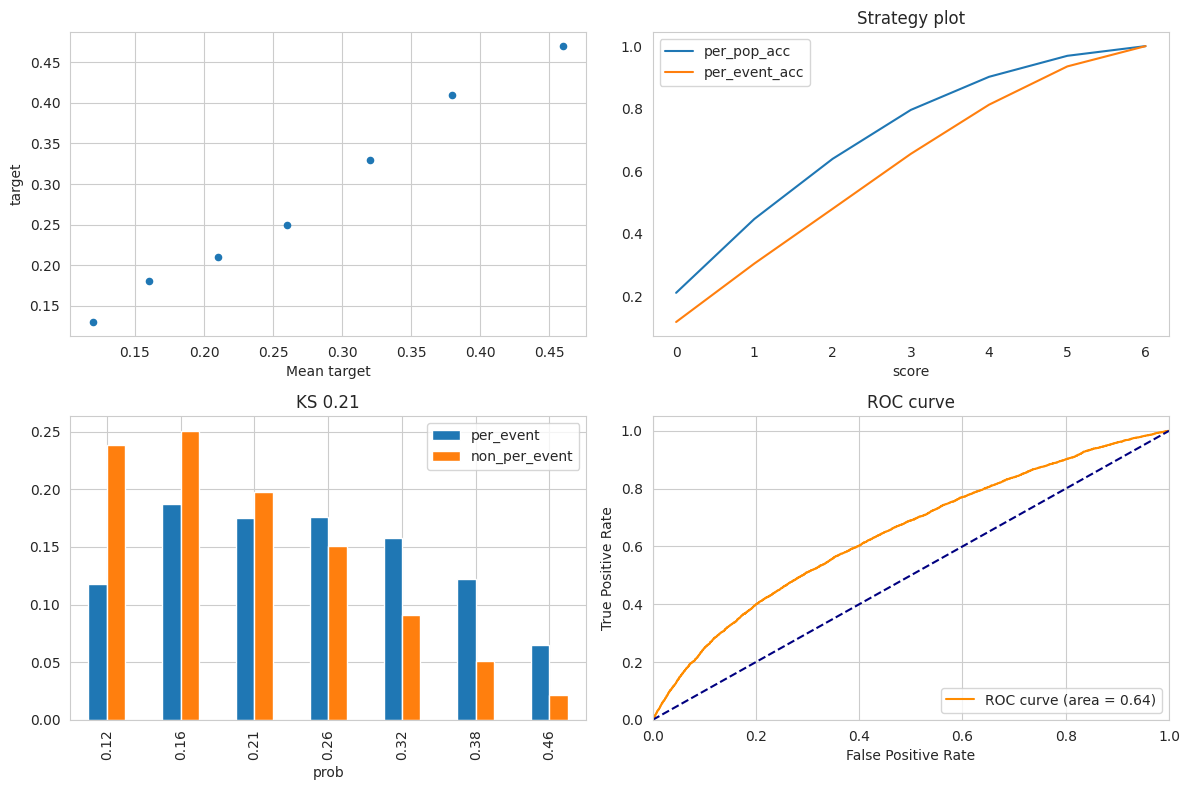

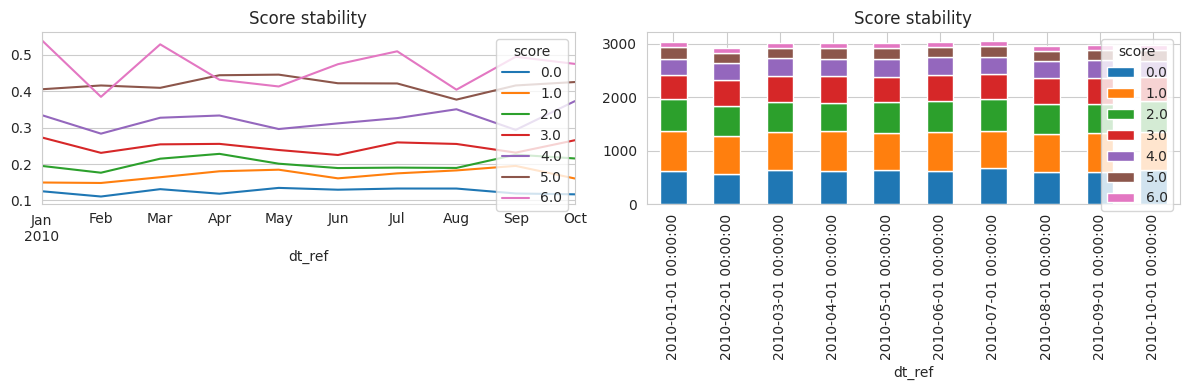

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00001,0.062380,0.0
1,1,2,0.00016,0.088029,0.0
2,2,3,0.00008,0.082096,0.0
3,3,4,0.00000,0.062266,0.0
4,4,5,0.00002,0.080539,0.0
5,5,6,0.03299,0.044328,0.3


CPU times: user 3.11 s, sys: 587 ms, total: 3.7 s
Wall time: 3.09 s


In [29]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.2,random_state=42, max_iter=1000)\
        .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x, n_bins=7)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

## Let's try vanilla neural nets

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.11,0.09,1513.0,141.0,1372.0,0.13,0.05,0.15,0.35,0.13,0.05,0.40
1,1.0,0.14,0.17,2395.0,404.0,1991.0,0.20,0.15,0.21,0.70,0.33,0.20,0.76
2,2.0,0.18,0.19,1882.0,361.0,1521.0,0.16,0.13,0.16,0.82,0.48,0.34,0.84
3,3.0,0.21,0.21,1693.0,353.0,1340.0,0.14,0.13,0.14,0.91,0.62,0.47,0.93
4,4.0,0.25,0.22,1427.0,316.0,1111.0,0.12,0.12,0.12,0.98,0.74,0.58,0.98
5,5.0,0.29,0.31,1007.0,311.0,696.0,0.08,0.12,0.08,1.54,0.83,0.70,1.38
6,6.0,0.33,0.35,840.0,295.0,545.0,0.07,0.11,0.06,1.86,0.90,0.81,1.55
7,7.0,0.37,0.41,593.0,242.0,351.0,0.05,0.09,0.04,2.37,0.95,0.90,1.82
8,8.0,0.42,0.41,417.0,172.0,245.0,0.03,0.06,0.03,2.42,0.98,0.96,1.82
9,9.0,0.49,0.49,207.0,101.0,106.0,0.02,0.04,0.01,3.28,1.00,1.00,2.18


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.28,0.29,1197.4,269.6,927.8,0.1,0.1,0.1,1.52,0.7,0.6,1.27


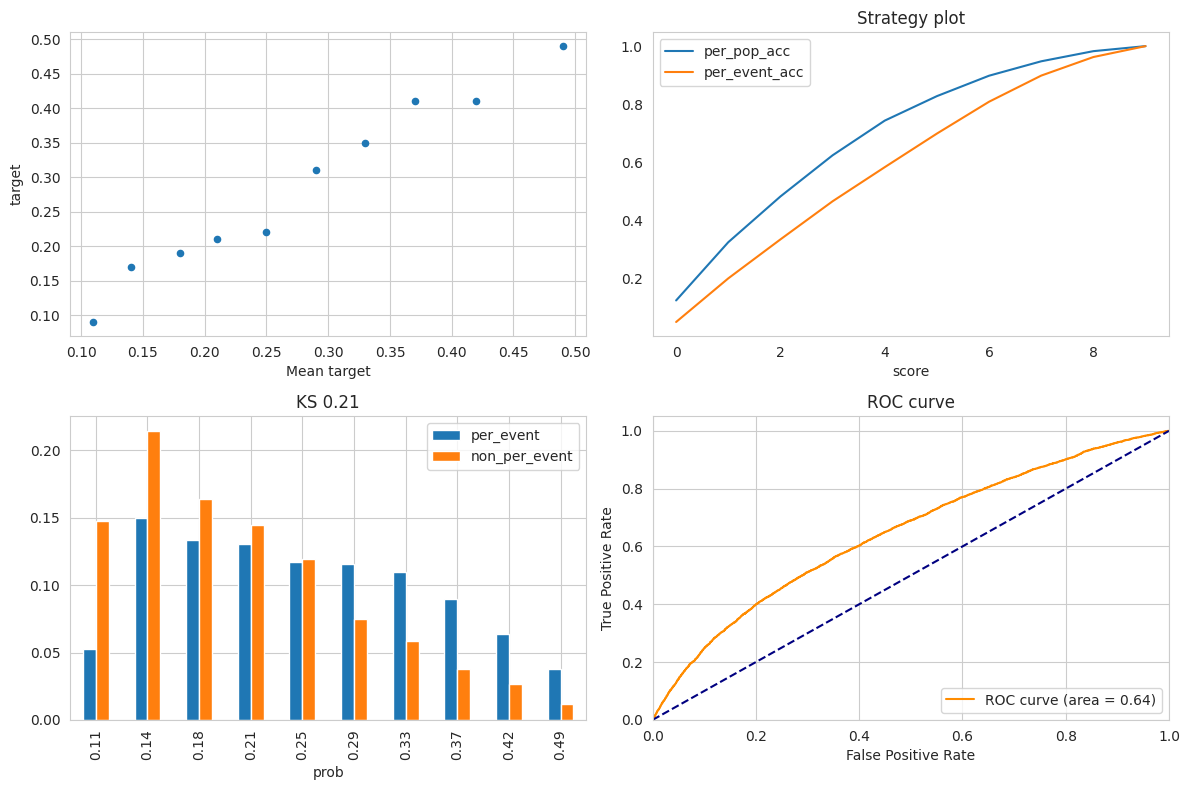

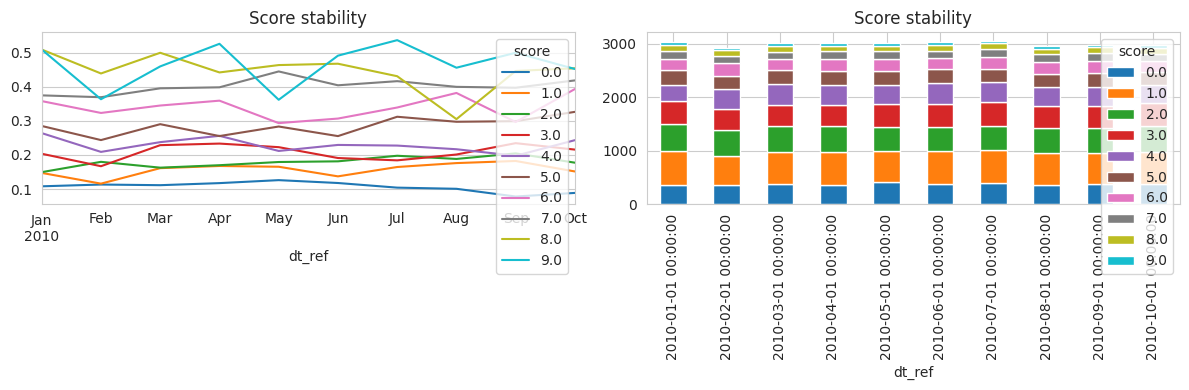

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00033,0.128140,0.0
1,1,2,0.00755,0.118768,0.0
2,2,3,0.01152,0.084842,0.2
3,3,4,0.04525,0.103700,0.2
4,4,5,0.00057,0.088074,0.1
5,5,6,0.00065,0.088091,0.1
6,6,7,0.00149,0.096570,0.0
7,7,8,0.04957,0.051154,0.1
8,8,9,0.45591,0.118418,0.4


CPU times: user 11.7 s, sys: 556 ms, total: 12.2 s
Wall time: 11.9 s


In [30]:
%%time
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=[20], random_state=42)\
        .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

## Let's try simple decision trees

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.12,0.13,2525.0,317.0,2208.0,0.21,0.12,0.24,0.49,0.21,0.12,0.58
1,1.0,0.16,0.18,2829.0,504.0,2325.0,0.24,0.19,0.25,0.75,0.45,0.30,0.80
2,2.0,0.21,0.21,2302.0,472.0,1830.0,0.19,0.18,0.20,0.89,0.64,0.48,0.93
3,3.0,0.26,0.25,1875.0,474.0,1401.0,0.16,0.18,0.15,1.16,0.80,0.66,1.11
4,4.0,0.32,0.33,1268.0,424.0,844.0,0.11,0.16,0.09,1.73,0.90,0.81,1.47
5,5.0,0.38,0.41,804.0,330.0,474.0,0.07,0.12,0.05,2.40,0.97,0.94,1.82
6,6.0,0.46,0.47,371.0,175.0,196.0,0.03,0.06,0.02,3.07,1.00,1.00,2.09


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.27,0.28,1710.57,385.14,1325.43,0.14,0.14,0.14,1.5,0.71,0.61,1.26


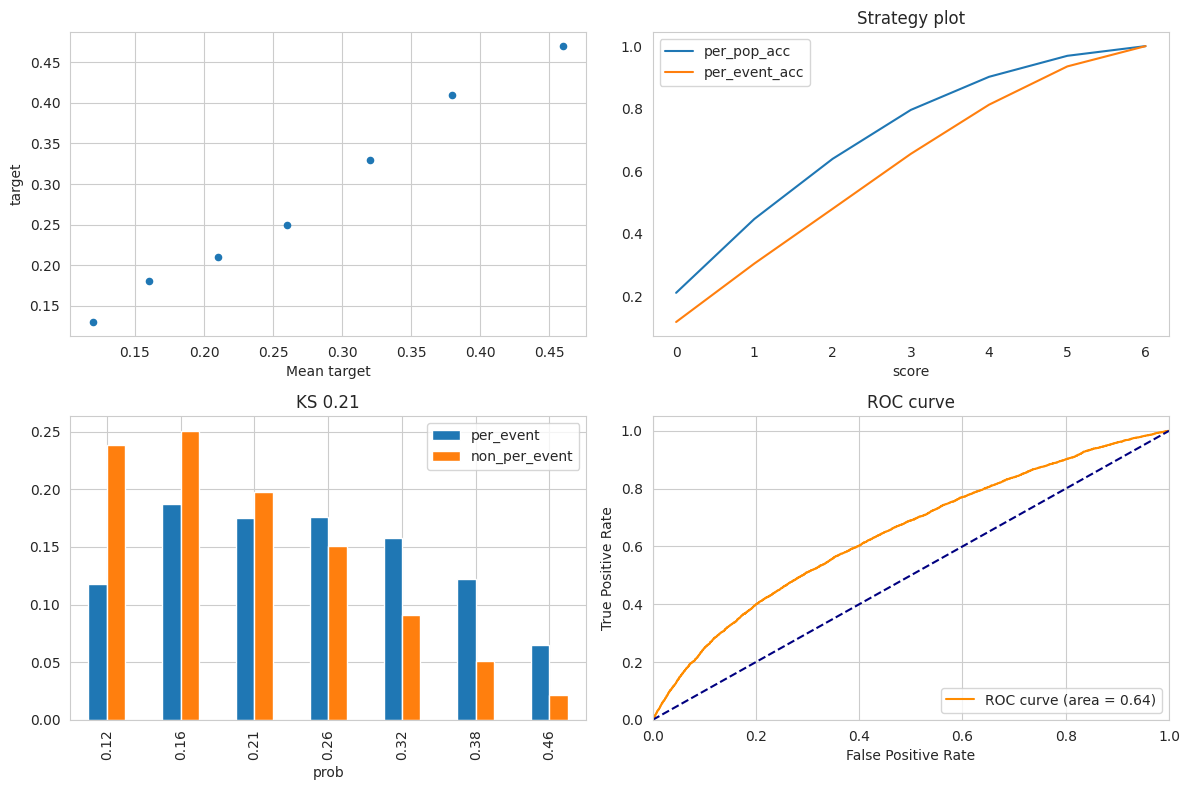

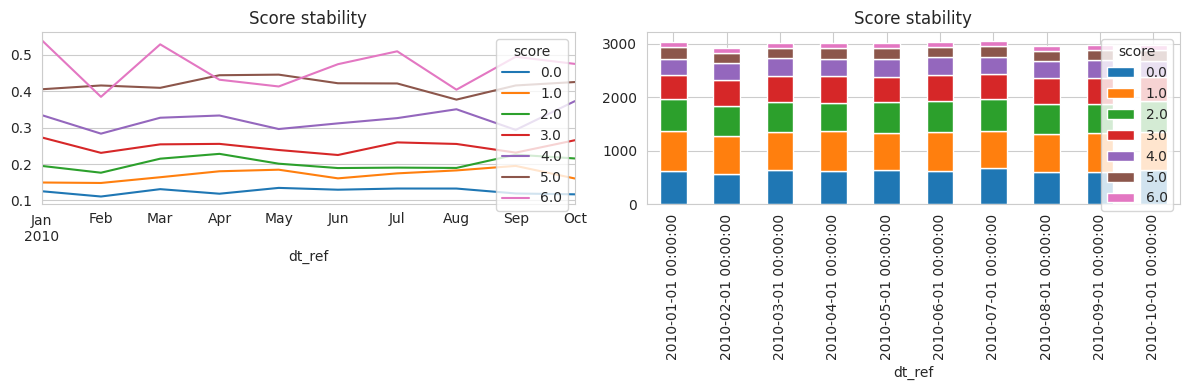

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00001,0.062380,0.0
1,1,2,0.00016,0.088029,0.0
2,2,3,0.00008,0.082096,0.0
3,3,4,0.00000,0.062266,0.0
4,4,5,0.00002,0.080539,0.0
5,5,6,0.03299,0.044328,0.3


CPU times: user 3.19 s, sys: 537 ms, total: 3.73 s
Wall time: 3.2 s


In [31]:
%%time
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(
        criterion='entropy',
        min_samples_split=0.05,
        #max_depth=4,
        max_leaf_nodes=20,
        random_state=42)\
        .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x, n_bins=7)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

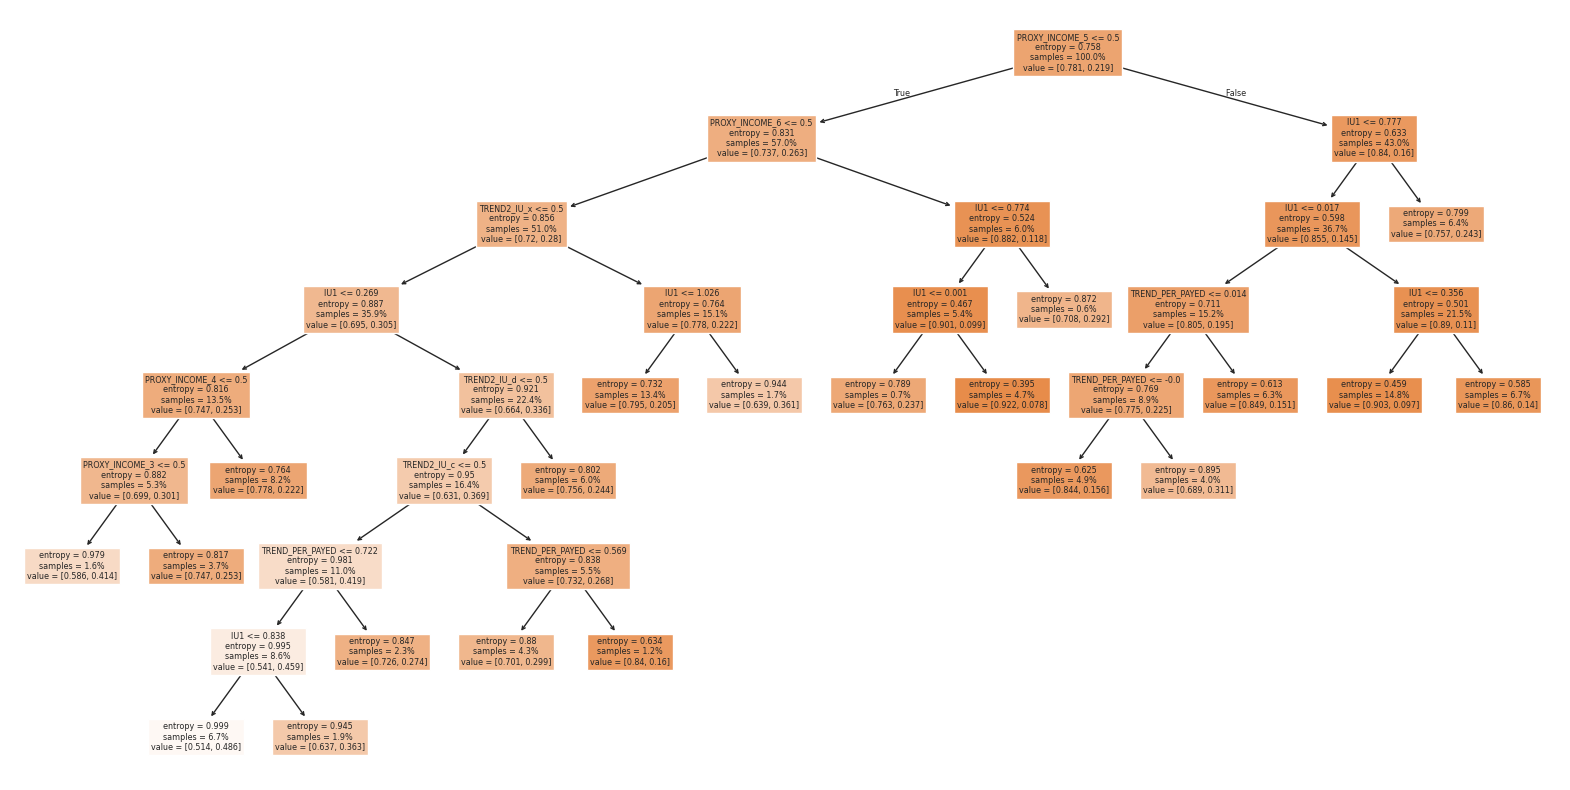

In [32]:
plt.figure(figsize=(20,10))
plot_tree(clf,filled=True,proportion=True, feature_names=vars);

In [33]:
%%time
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=30, random_state=42)\
     .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

TypeError: BaggingClassifier.__init__() got an unexpected keyword argument 'base_estimator'

## Let's try a boosting algoritm

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.12,0.13,2525.0,317.0,2208.0,0.21,0.12,0.24,0.49,0.21,0.12,0.58
1,1.0,0.16,0.18,2829.0,504.0,2325.0,0.24,0.19,0.25,0.75,0.45,0.30,0.80
2,2.0,0.21,0.21,2302.0,472.0,1830.0,0.19,0.18,0.20,0.89,0.64,0.48,0.93
3,3.0,0.26,0.25,1875.0,474.0,1401.0,0.16,0.18,0.15,1.16,0.80,0.66,1.11
4,4.0,0.32,0.33,1268.0,424.0,844.0,0.11,0.16,0.09,1.73,0.90,0.81,1.47
5,5.0,0.38,0.41,804.0,330.0,474.0,0.07,0.12,0.05,2.40,0.97,0.94,1.82
6,6.0,0.46,0.47,371.0,175.0,196.0,0.03,0.06,0.02,3.07,1.00,1.00,2.09


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.27,0.28,1710.57,385.14,1325.43,0.14,0.14,0.14,1.5,0.71,0.61,1.26


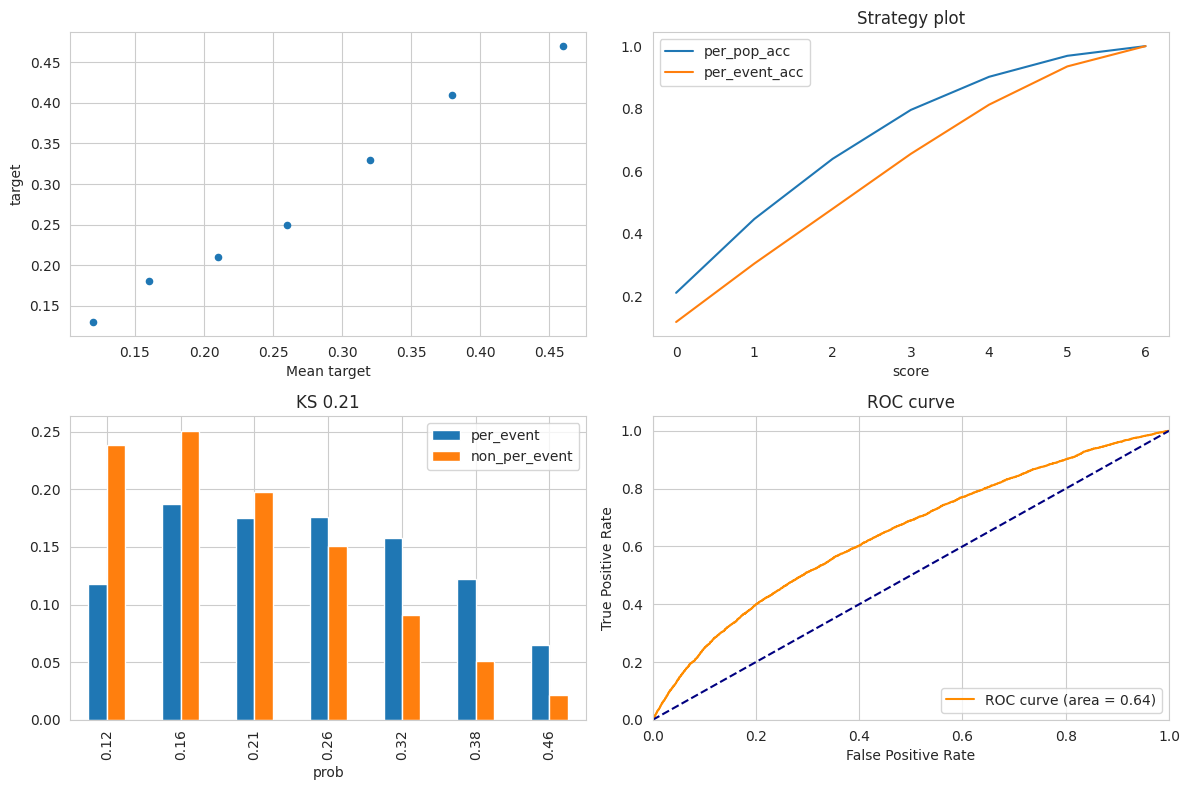

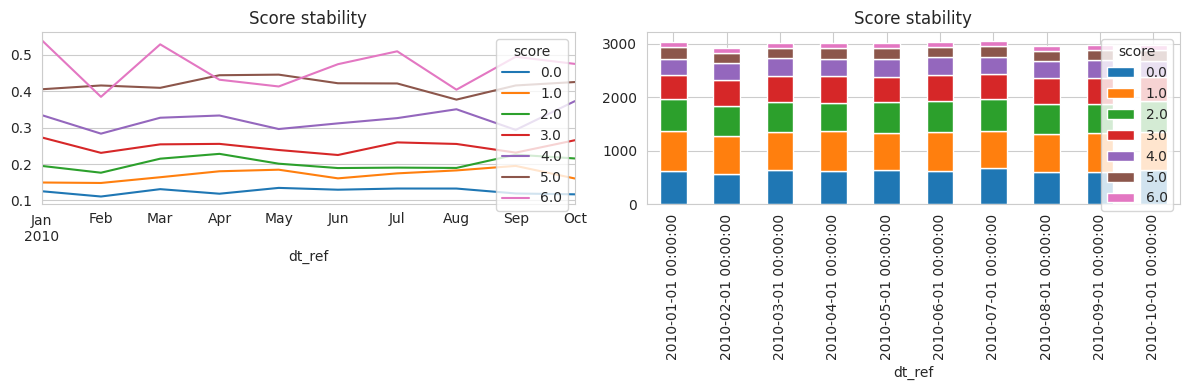

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00001,0.062380,0.0
1,1,2,0.00016,0.088029,0.0
2,2,3,0.00008,0.082096,0.0
3,3,4,0.00000,0.062266,0.0
4,4,5,0.00002,0.080539,0.0
5,5,6,0.03299,0.044328,0.3


CPU times: user 3.53 s, sys: 528 ms, total: 4.06 s
Wall time: 3.52 s


In [34]:
%%time
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(min_samples_leaf=5,random_state=42)\
         .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x,n_bins=7)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

# Model quality check

Checking if the model has bias by income level

In [35]:
(
    df
    .pivot_table(index='score',columns='PROXY_INCOME',values='BILL_AMT1')
    .fillna(0)
    .apply(lambda x:x/x.sum())
    .round(2)
    .style.background_gradient()
)

PROXY_INCOME,2,3,4,5,6
score,,,,,
0.000000,0.000000,0.000000,0.030000,0.080000,0.160000
1.000000,0.000000,0.070000,0.100000,0.100000,0.200000
2.000000,0.090000,0.160000,0.140000,0.130000,0.210000
3.000000,0.190000,0.190000,0.170000,0.150000,0.430000
4.000000,0.210000,0.200000,0.150000,0.210000,0.000000
5.000000,0.260000,0.160000,0.170000,0.310000,0.000000
6.000000,0.250000,0.210000,0.230000,0.000000,0.000000


In [36]:
# trying to understand the behaviour of sensible variables.
(
    df
    .copy()
    .assign(isMale=lambda x:x['SEX']==1)
    .groupby('score')
    .agg(
        mean_age     = ('AGE','mean'),
        max_age     = ('AGE','max'),
        per_male     = ('isMale','mean'),
        per_MARRIED  = ('MARRIED','mean'),
        target       = ('target','mean'),
    )
    .astype({'mean_age':'int'})
    .round(2)
    .style.background_gradient(axis=0)
)

,mean_age,max_age,per_male,per_MARRIED,target
score,,,,,
0.000000,34,70,0.250000,0.310000,0.130000
1.000000,36,75,0.380000,0.550000,0.170000
2.000000,34,79,0.370000,0.410000,0.200000
3.000000,35,75,0.460000,0.500000,0.250000
4.000000,35,70,0.510000,0.470000,0.320000
5.000000,35,73,0.530000,0.530000,0.420000
6.000000,37,73,0.670000,0.600000,0.470000


In [37]:
df['SEX'].value_counts()

SEX
2    18112
1    11888
Name: count, dtype: int64